# 08 Local Active Subspaces
The design of response surfaces with Active Subspaces and Gaussian
process regression can be improved in accuracy with a local formulation;
moreover a definition of a local active subspace is introduced to classify the
parameter space [Romor, Francesco, Marco Tezzele, and Gianluigi Rozza. "A local
approach
to parameter space reduction for regression and classification
tasks."](https://arxiv.org/pdf/2107.10867.pdf).

Let $\mathbf{X}:(\Omega, \mathcal{A},
P)\rightarrow\mathcal{X}\subset\mathbb{R}^{n},\qquad \frac{d\mathbf{X}_{\#}(P)}{d\lambda}={\boldsymbol{\mu}}$ be the inputs continuous random
variable. Given a partition of the domain
$\mathcal{P}:=\{S_{i}\}_{i\in\{1,\dots, d\}}$
      and a map $r:\mathcal{P}\rightarrow\{1,\dots,n_{r}\},\,n_{r}\ll n$
      representing the local reduced dimension, the local ridge approximation
      with active subspaces of ($f$, $\boldsymbol{\mu}$) is the function
      $R_{AS}(r,f,
      \boldsymbol{\mu}):\mathcal{X}\subset\mathbb{R}^{n}\rightarrow\mathbb{R}$
      that is defined locally for every $S_i\in\mathcal{P}$ as
  $$
      \left.g\right|_{S_i} = \mathbb{E}_{\boldsymbol{\mu}_{i}}[f|P_{r(S_i), i}]
  $$
  where
  $\boldsymbol{\mu}_{i}:=(1/\boldsymbol{\mu}({S_{i}}))\cdot\left.\boldsymbol{\mu}\right|_{S_{i}}\mathbb{R}^n$,
  and $P_{r, i}:S_i\subset\mathbb{R}^{n}\rightarrow$ is the orthogonal projector
  with rank $r$ that satisfies the minimization problem
  $$
      P_{r, i} = \argmin_{\substack{P^{2}=P, P=P^{T},\\
      rank(P)=r}}\,\mathbb{E}_{\boldsymbol{\mu}_{i}}\| (Id-P)\nabla f\|^{2} =
      \argmin_{\substack{P^{2}=P, P=P^{T},\\ rank(P)=r}}\,
      \text{tr}((Id-P)\mathbb{E}_{\boldsymbol{\mu}_{i}}\left[\nabla
          f\otimes\nabla f\right](Id-P)).
  $$

  We use the library [scikit-learn](https://scikit-learn.org/stable/) for clustering and [GPy](https://github.com/SheffieldML/GPy) for Gaussian process regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from athena import Normalizer, TopDownHierarchicalAS, KMeansAS, KMedoidsAS, ClassifyAS, plot_scores

We consider the toy problem
$$f:[0, 1]^2\rightarrow\mathbb{R},\qquad
f(\mathbf{x})\mapsto x_0^4-x_1^4

In [2]:
def quartic_2d(X, n):
    # Unnormalize inputs
    x = n.inverse_transform(X)

    f = x[:, 0]**4 - x[:, 1]**4
    df = np.empty(x.shape)
    df[:, 0] = 4.0 * x[:, 0]**3
    df[:, 1] = -4.0 * x[:, 1]**3
    return f, df
    
n_params = 2
n_samples = 400
n_samples_test = 600

lb = np.array(n_params * [0])
ub = np.array(n_params * [1])

scaler = Normalizer(lb, ub)
real_inputs = np.random.uniform(scaler.lb, scaler.ub, (n_samples, n_params))
inputs = scaler.fit_transform(real_inputs)


# output values (f) and gradients (df)
outputs, gradients = quartic_2d(inputs, scaler)

real_inputs_test = np.random.uniform(scaler.lb, scaler.ub,
                                     (n_samples_test, n_params))
inputs_test = scaler.fit_transform(real_inputs_test)
outputs_test = quartic_2d(inputs_test, scaler)[0]

This is the dictionary that the class *TopDownHierarchicalAS* needs to perform a
hierarchical top-down clustering. The metric we employ is the AS metric:
$$
\| x_i - x_j \|_{\Lambda} = \sqrt{(x_i - x_j)^T \mathbf{W} \Lambda^2
    \mathbf{W}^T (x_i - x_j)}
$$
it will cluster the training samples along the AS as direction of preference. In
the following by *score* it is meant the $R^2$ score, computed on a validation
set if passed, otherwise on the passed test set.

In [3]:
config = {
    'inputs_test': inputs_test,
    'outputs_test': outputs_test,
    'inputs_val': None,
    'outputs_val': None,
    'method': 'kmedoids', # methods used for clustering at each refinement level
    'max_clusters': 3, # number of clusters
    'as_dim': 1, # global AS dimension
    'random_state': 0, # random state used for clustering with scipy
    'max_red_dim': 2, # maximum dimension of local AS
    'max_children': 3,
    'min_children': 3,
    'min_local': 10, # minimum number of elements in each local cluster
    'dim_cut': 0.7,
    'normalization': 'uniform', # normalization of the samples of each cluster
    'metric': 'as', # metric AS-informed defined above
    'refinement_criterion': 'force', # when possible, split the clusters
    'as_dim_criterion': 'residual', # choose the AS dimension minimizing the residual energy
    'score_tolerance': 0.99, # if the score is above or equal, stop refining the node/local cluster
    'minimum_score': 0.98,# if the local scores are not below this tolerance, the AS dimension is incerased further until it reaches 'max_dim_refine_further'. Pass 'None' or a value > 1, to avoid further refinements of the result.
    'max_dim_refine_further':2, # maximum AS dimension reached with the final increasing of the local AS dimensions
    'verbose': True, # If true, it prints the final state (from 1 to 7) of refinement of the leaves, the number of leaves (final local clusters), the scores on the test set.
}

First hierarchical top-down clustering is performed. Afterwards, the dimension
of the local clusters is raised in case the local score is below the
'score_tolerance' provided: in this case only the dimension of the first cluster
is raised from 1 to 2. The 'Test scores' are the $R^2$ scores of the response
surfaces built with the global AS and local AS and the mean absolute regression
error corresponding to the global AS and the local AS.

score is: 0.61  r_dim is:  1  state is:  4  n_elem :  138
score is: 1.00  r_dim is:  1  state is:  2  n_elem :  140
score is: 0.99  r_dim is:  1  state is:  2  n_elem :  122
Hierarchical top-down clustering completed with states
7  :  node not refined
n_leaves: 3
Test score: [0.74791955 0.97124374 0.15370211 0.03941763]
Start refining: increasing the as dimension when possible.
score is: 1.00  r_dim is:  2  state is:  4  n_elem :  138
score is: 1.00  r_dim is:  1  state is:  2  n_elem :  140
score is: 0.99  r_dim is:  1  state is:  2  n_elem :  122
Finished increasing as dimension when possible.
n_leaves:  3
Test score:  [0.74791955 0.99797489 0.15370211 0.01012951]


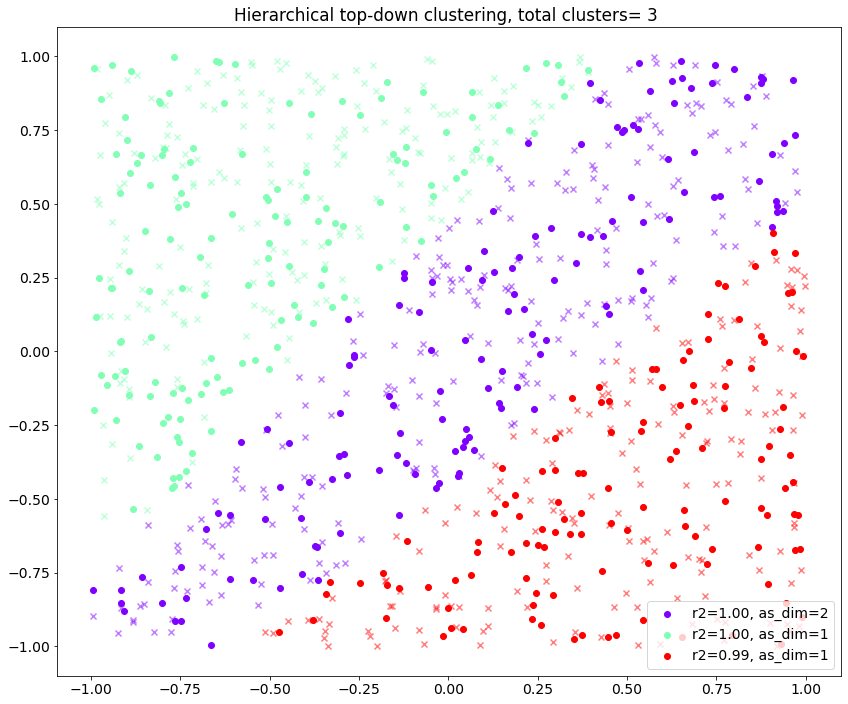

In [4]:
# TopDownHierarchicalAS clusters
cluster_as = TopDownHierarchicalAS()
cluster_as.fit(inputs, outputs, gradients, config)
cluster_as.plot_clusters(with_test=True)

Returns the number of classes and the labels of the inputs related to a
classification procedure that groups samples based on a local AS dimension:
1. for each input a local AS dimension is assigned: we take the min AS dimensions of a number equal to 'neighbour_resampling' points among
   'n_neighbours'. So in this case we take the minimum of $\binom 6 5$ AS
   dimensions. Another option is assigning to each sample the local AS itself.
2. a distance matrix is computed using the previous information. If in the
   previous step the AS itself was assigned, then a Grassmanian distance could
   be employed.
3. a graph is built, imposing that the inputs with the same local AS dimension belong
   to the same connected components
4. the connected components of the graph are evlauated and returned as the
   classes of the procedure

Finally we employ a multilayer perceptron to get the decision boundaries.

Number of components:  3


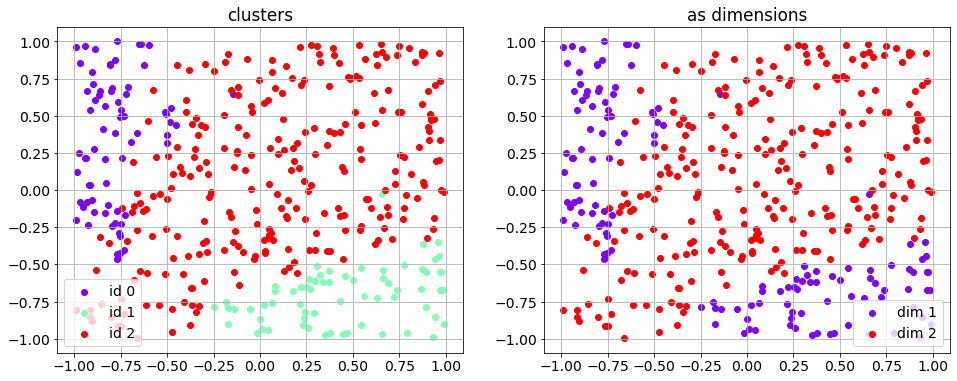

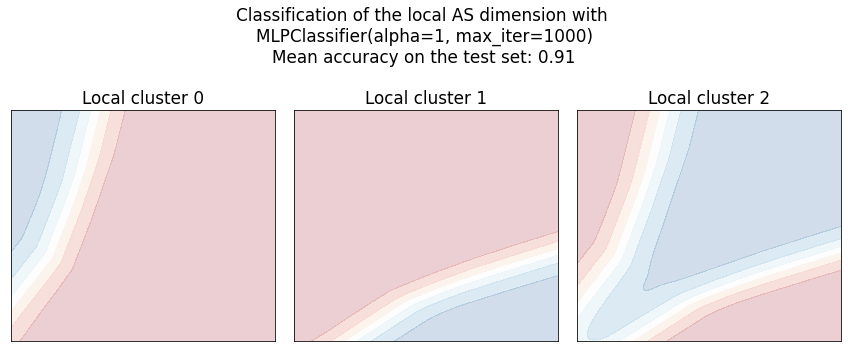

Classification error on train set 0.9125


In [5]:
agg = ClassifyAS()
n_c, labels = agg.fit(inputs,
                 gradients,
                 n_neighbours=6,
                 threshold=0.9999,
                 neighbour_resampling=5)
print("Number of components: ", n_c)
agg.plot()
score = agg.plot_decision_boundaries()
print("Classification error on train set {}".format(score))

Finally, perform a comparison of hierarchical top-down with a single global
clustering with k-means or k-medoids (with AS-informed metric). For consistency
of the implementations, hierarchical top-down clustering with only one refinement
layer should have the same results as k-medoids (if the clustering method chosen is k-medoids).

Local AS with 2 clusters
Local AS with 3 clusters
Local AS with 4 clusters
Local AS with 5 clusters
Local AS with 6 clusters
Local AS with 7 clusters
Clustering with kmeans method
r2_local = [0.91629803 0.97544551 0.98402341 0.98509574 0.9916772  0.9932403 ]
mae_local = [0.07312509 0.03323621 0.02720849 0.0253276  0.01858324 0.01674812]


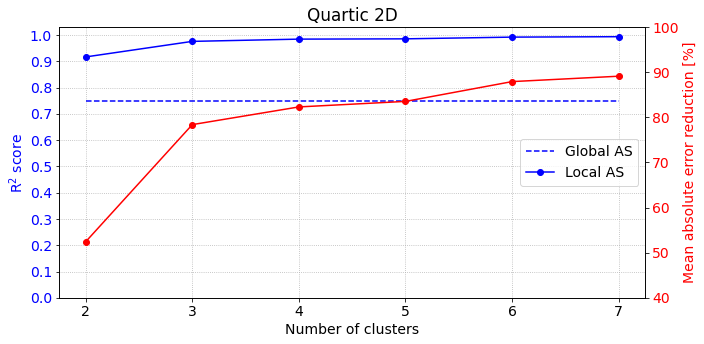

In [11]:
def plot_scores_(possible_clusters, inputs, outputs, gradients, config):
    """
    method='kmeans' or 'kmedoids' or 'divisive'
    """
    scores = []
    for n_clusters in possible_clusters:
        if config['method'] == 'kmeans':
            print("Local AS with {} clusters".format(n_clusters))
            config['max_clusters'] = n_clusters
            cluster_as = KMeansAS()
        elif config['method'] == 'kmedoids':
            print("Local AS with {} clusters".format(n_clusters))
            config['max_clusters'] = n_clusters
            cluster_as = KMedoidsAS()
        elif config['method'] == 'top-down':
            config['max_clusters'] = n_clusters
            config['min_children'] = n_clusters
            config['max_children'] = n_clusters
            cluster_as = TopDownHierarchicalAS()
        
        cluster_as.fit(inputs, outputs, gradients, config)
        score = cluster_as.compute_scores(inputs_test, outputs_test)
        scores.append(score)
    scores = np.asarray(scores)
    print("Clustering with {} method".format(config['method']))
    print('r2_local = {}'.format(scores[:, 1]))
    print('mae_local = {}'.format(scores[:, 3]))
    plot_scores(possible_clusters, scores, plot_config)

plot_config = {
    'figsize': (10, 5),
    'title': 'Quartic 2D',
    'mae_bottom': 40,
    'mae_top': 100,
    'r2_bottom': 0.67,
    'r2_top': 1.03,
    'loc': 7,
    'main': 'r2',
}

# convergence study
cl_min, cl_max = 2, 8
possible_clusters = np.arange(cl_min, cl_max, 1)

# k-means
config['method'] = 'kmeans'
plot_config['filename'] = 'quartic_2d_r2_kmeans_{}_{}.pdf'.format(cl_min, cl_max)
plot_scores_(possible_clusters, inputs, outputs, gradients, config)

Local AS with 2 clusters
Local AS with 3 clusters
Local AS with 4 clusters
Local AS with 5 clusters
Local AS with 6 clusters
Local AS with 7 clusters
Clustering with kmedoids method
r2_local = [0.96847957 0.97125424 0.99152696 0.987958   0.99179162 0.99186473]
mae_local = [0.04845355 0.03936355 0.02290987 0.02211401 0.01967995 0.0187243 ]


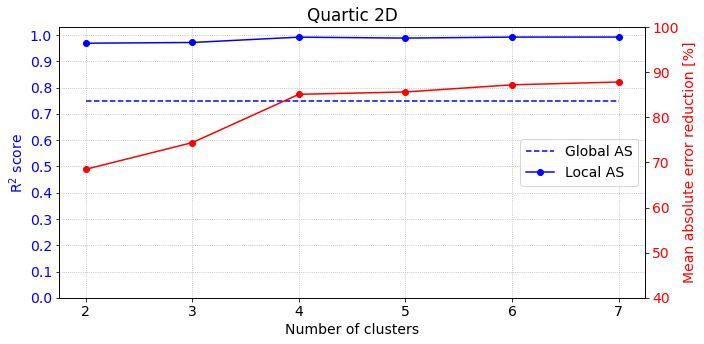

In [12]:
# k-medoids
config['method'] = 'kmedoids'
plot_config['filename'] = 'quartic_2d_r2_kmedoids_{}_{}.pdf'.format(cl_min, cl_max)
plot_scores_(possible_clusters, inputs, outputs, gradients, config)

score is: 0.96  r_dim is:  1  state is:  4  n_elem :  192
score is: 0.91  r_dim is:  1  state is:  4  n_elem :  208
Hierarchical top-down clustering completed with states
7  :  node not refined
n_leaves: 2
Test score: [0.74791955 0.96831291 0.15370211 0.04870533]
score is: 0.61  r_dim is:  1  state is:  4  n_elem :  138
score is: 1.00  r_dim is:  1  state is:  2  n_elem :  140
score is: 0.99  r_dim is:  1  state is:  2  n_elem :  122
Hierarchical top-down clustering completed with states
7  :  node not refined
n_leaves: 3
Test score: [0.74791955 0.97124374 0.15370211 0.03941763]
score is: 0.93  r_dim is:  1  state is:  4  n_elem :  70
score is: 1.00  r_dim is:  1  state is:  2  n_elem :  125
score is: 0.99  r_dim is:  1  state is:  4  n_elem :  113
score is: 0.92  r_dim is:  1  state is:  4  n_elem :  92
Hierarchical top-down clustering completed with states
7  :  node not refined
n_leaves: 4
Test score: [0.74791955 0.99038482 0.15370211 0.0238811 ]
score is: 1.00  r_dim is:  1  state 

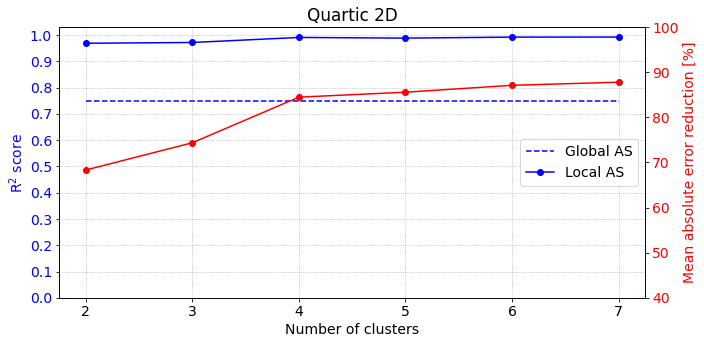

In [9]:
# top-down clustering
config['method'] = 'top-down'
config['minimum_score'] = None
config['max_red_dim'] = 1
config['verbose'] = True
plot_config['filename'] = 'quartic_2d_r2_top-down_{}_{}.pdf'.format(cl_min, cl_max)
plot_scores_(possible_clusters, inputs, outputs, gradients, config)